# Project 1 - Yellow Taxi's 

### Find a dataset to use

The dataset chosen was the January 2024 dataset for yellow taxis in New York City. I selected this dataset because I find the US fascinating, with how different it is from the UK. I wanted to see if I could learn something new about the differences. This dataset provided a great opportunity to explore taxi patterns in New York City.

https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

### Troubles

Problem: The dataset is a format called parquet, its can't read using read_csv since its a different format

Solution: <b>Use pip to install Pyarrow or Fast Parquet</b>. I choose Pyarrow since its more recommended, its said to have better performance and <b>adpotion</b>.

### Imports

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np


In [143]:
file_path = 'yellow_tripdata_2024-01.parquet'
df = pd.read_parquet(file_path)

In [144]:
df.head() # It works

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


Slight investigation

In [145]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee'],
      dtype='object')

In [146]:
df.shape

(2964624, 19)

In [147]:
# Calculate the number of NaN values in each column
na_counts = df.isna().sum()

# Filter the counts to show only columns with more than 0 NaN values
na_counts_filtered = na_counts[na_counts > 0]

# Display the filtered results
na_counts_filtered

# There's 5 columns to be careful of when working with them.
# Airport_Fee makes sense since not everyone pays one, 
# Congestion_surcharge is fine for the same reason

# Passenger_count shouldn't have missing entryies and is something to be considered.
# However its definetly suspicious all 5 columns have the same number of missing entries


passenger_count         140162
RatecodeID              140162
store_and_fwd_flag      140162
congestion_surcharge    140162
Airport_fee             140162
dtype: int64

Given the large volume of data available (2964624 Rows Nearly 3 Million and 19 Columns), our results are likely to be reliable.

### Deciding which columns to drop

Before going further I should decide which columns I would like to investigate first and what questions I want to answer. Doing this now stops me from cleaning data that I will not end up using data so its best to do it now.

#### First I would like to do General analysis.

- 1) What are the busiest times of day for pickups and drop-offs? 
(Analyze tpep_pickup_datetime and tpep_dropoff_datetime)

- 2) How does trip distance vary by time of day or day of the week? 
(tpep_pickup_datetime, trip_distance)

I would like to do more but I will choose more questions later on. So each question will have its own dataset since they need different columns dropped

### Busiest times for pickups and drops

We need the columns, 'tpep_pickup_datetime', 'tpep_dropoff_datetime'

In [148]:
df_q1 = df[['tpep_pickup_datetime', 'tpep_dropoff_datetime']].copy()
df_q1.head()

# Copy is VERY IMPORTANT to ensure that df_q1 is a separate object from the original DataFrame.
# Without .copy(), df_q1 would be a view of the original DataFrame. This means that any changes
# made to df_q1 would also affect the original DataFrame (df) and vice versa. By using .copy(),
# we create an independent DataFrame that we can modify without impacting the original data.

,tpep_pickup_datetime,tpep_dropoff_datetime
0,2024-01-01 00:57:55,2024-01-01 01:17:43
1,2024-01-01 00:03:00,2024-01-01 00:09:36
2,2024-01-01 00:17:06,2024-01-01 00:35:01
3,2024-01-01 00:36:38,2024-01-01 00:44:56
4,2024-01-01 00:46:51,2024-01-01 00:52:57


In [149]:
df_q1.info() 
# The data types for the two columns are both datetime64.
# This appropriate for our question to investigate busiest times

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 2 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[us]
 1   tpep_dropoff_datetime  datetime64[us]
dtypes: datetime64[us](2)
memory usage: 45.2 MB


Lets count how many pickups occured in each hour across the month. Like which ones where picked at 9 etc.

In [150]:
# Make a row of pick up hours
df_q1["pickup_hour"] = df_q1["tpep_pickup_datetime"].dt.hour
# This line gives an error if "copy()" was not implemented earlier.

df_q1.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,pickup_hour
0,2024-01-01 00:57:55,2024-01-01 01:17:43,0
1,2024-01-01 00:03:00,2024-01-01 00:09:36,0
2,2024-01-01 00:17:06,2024-01-01 00:35:01,0
3,2024-01-01 00:36:38,2024-01-01 00:44:56,0
4,2024-01-01 00:46:51,2024-01-01 00:52:57,0


In [151]:
# Group by the hour and count the occurrences
hourly_pickup_counts = df_q1['pickup_hour'].value_counts().sort_index()

# Convert the Series to a DataFrame so we can see 2 columns
hourly_pickup_counts_df = hourly_pickup_counts.reset_index()
# Reset index turns the index of unique values into a column, thus into a df too.

# Name the new column
hourly_pickup_counts_df.columns = ['Hour', 'Pickup_Count']

print(hourly_pickup_counts_df)

    Hour  Pickup_Count
0      0         79094
1      1         53627
2      2         37517
3      3         24811
4      4         16742
5      5         18764
6      6         41429
7      7         83719
8      8        117209
9      9        128970
10    10        138778
11    11        150542
12    12        164559
13    13        169903
14    14        182898
15    15        189359
16    16        190201
17    17        206257
18    18        212788
19    19        184032
20    20        159989
21    21        160888
22    22        143261
23    23        109287


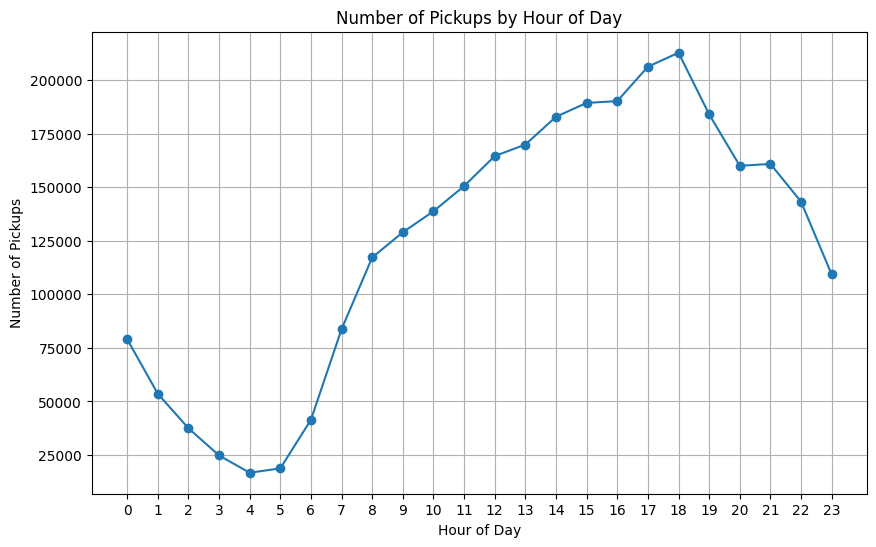

In [152]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(hourly_pickup_counts.index, hourly_pickup_counts.values, marker='o')
plt.title('Number of Pickups by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Pickups')
plt.xticks(range(0, 24))  # Ensure x-axis shows each hour from 0 to 23
plt.grid(True)
plt.show()

We can see that the lowest number of pickups occured during 4-5 AM. The highest at 4-5 PM

This pattern is quite symmetrical.

### How does trip distance vary across day of the week?

I also need to check for events during the month of January that could lead to anomalies.

In [153]:
df_q2 = df[["tpep_pickup_datetime", "trip_distance"]].copy()
df_q2.head()

,tpep_pickup_datetime,trip_distance
0,2024-01-01 00:57:55,1.72
1,2024-01-01 00:03:00,1.80
2,2024-01-01 00:17:06,4.70
3,2024-01-01 00:36:38,1.40
4,2024-01-01 00:46:51,0.80


In [154]:
df_q2['day_of_week'] = df_q2['tpep_pickup_datetime'].dt.day_name()
df_q2.head()

,tpep_pickup_datetime,trip_distance,day_of_week
0,2024-01-01 00:57:55,1.72,Monday
1,2024-01-01 00:03:00,1.80,Monday
2,2024-01-01 00:17:06,4.70,Monday
3,2024-01-01 00:36:38,1.40,Monday
4,2024-01-01 00:46:51,0.80,Monday


In [155]:
df_q2["day_of_week"].value_counts().sort_values(ascending=False)

day_of_week
Wednesday    495032
Tuesday      463664
Thursday     428593
Saturday     421158
Friday       408588
Monday       408277
Sunday       339312
Name: count, dtype: int64

Although the results suggest that wednesday is the day with the most work during January with the highest count this is not true.

The reasons for this is that Monday, Tuesday and Wednesday all had 5 days during the month whilist the others had 4 so this is unfair.

To make it fair we need to divide the results for each column appropriately.

In [156]:
print(495032/5)
# A figure used to check if division below worked.

99006.4


In [157]:
# Get the count of each day
day_counts = df_q2["day_of_week"].value_counts()

# Define division factors
division_factors = {'Monday': 5, 'Tuesday': 5, 'Wednesday': 5, 'Thursday': 4, 'Friday': 4}

# Apply the division based on the division factors
adjusted_counts = day_counts.map(lambda count: count / division_factors.get(day_counts.index[day_counts == count].tolist()[0], 4))

# Sort the adjusted counts from largest to smallest
sorted_adjusted_counts = adjusted_counts.sort_values(ascending=False)

# Print the sorted adjusted counts
print(sorted_adjusted_counts)

day_of_week
Thursday     107148.25
Saturday     105289.50
Friday       102147.00
Wednesday     99006.40
Tuesday       92732.80
Sunday        84828.00
Monday        81655.40
Name: count, dtype: float64


We can see clearly that wednesday was in act not the day with the most activity but instead it was wednesday. Dividing reasonably has changed are results and made them more correct on which days are the most busy.

In [158]:
df_q2.groupby('day_of_week')['trip_distance'].mean()

day_of_week
Friday       3.603720
Monday       3.680769
Saturday     3.313225
Sunday       3.805528
Thursday     3.473969
Tuesday      4.149548
Wednesday    3.540238
Name: trip_distance, dtype: float64

People travel further by taxi on tuesdays.

### More Questions

Can I analyse location or are they all unique?
(Unique returns unique values, nunique returns the number)

In [159]:
df.shape

(2964624, 19)

In [160]:
df["PULocationID"].nunique()

260

In [161]:
df["PULocationID"].unique()

array([186, 140, 236,  79, 211, 148, 138, 246, 161, 113, 107, 158,  68,
        90, 132, 164, 237, 141, 263,   4, 238, 239, 233, 162, 262, 137,
       142, 229, 163, 234, 114, 232, 249,  43, 143,  48, 170,  50, 151,
        13,  66,  24, 144,  88, 166, 261,  75,  70,  42, 256, 209, 231,
       222,  87, 224, 265,  14, 125,  63,   7, 264,  41,  12,  74, 116,
       226, 244, 100,  40, 255, 216, 190, 215,  80,  52, 127, 169, 145,
        65,  25, 131, 260,  45,  78, 112, 181, 194,  33, 242,  93,  49,
       152,  83,  97, 136,  18,  20, 106, 243,  17, 146,  39, 223,  82,
       168, 126,  61,  47, 159, 189,  36, 179, 198,  77, 202, 188, 129,
       230,  89, 123, 228, 195, 225,  55,  95,  81, 247, 177,  37, 153,
       173,   6,  19, 157, 196,  69,  94, 217,  34, 193, 227, 251,  92,
        85, 197,  10, 117,  22,   9,  28, 248,  91, 178, 111, 165,  32,
         1,  72, 119,  62,  21,  86,  76, 130,  35,  64, 235, 205, 207,
       180, 135, 121, 134, 219, 212, 160,  67,  56, 257, 258, 12

I have found a CSV that turns the ID given into, "Borough","Zone","service_zone". 

#### Importing CSV

In [162]:
location_df = pd.read_csv("taxi_zone_lookup.csv")
location_df.head()


,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [163]:
location_df.tail()

,LocationID,Borough,Zone,service_zone
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NaN,NaN
264,265,NaN,Outside of NYC,NaN


<b>263 IS UNKNOWN</b>
<b>264 IS OUTSIDE OF NEW YORK CITY</b>

This table is for where people are picked up.

### Question: How frequently are airport fees applied to trips, and which locations are most affected? 

In [164]:
#df_q2.groupby('day_of_week')['trip_distance']

In [165]:
df_q3 = df[["Airport_fee", "PULocationID", "DOLocationID"]].copy()
df_q3.head() 

,Airport_fee,PULocationID,DOLocationID
0,0.0,186,79
1,0.0,140,236
2,0.0,236,79
3,0.0,79,211
4,0.0,211,148


In [166]:
df_q3['is_airport_fee'] = np.where(df_q3['Airport_fee'] > 0, 'yes', 'no')
df_q3.head()

,Airport_fee,PULocationID,DOLocationID,is_airport_fee
0,0.0,186,79,no
1,0.0,140,236,no
2,0.0,236,79,no
3,0.0,79,211,no
4,0.0,211,148,no


In [167]:
df_q3["is_airport_fee"].value_counts()
# Counts unique values

is_airport_fee
no     2731872
yes     232752
Name: count, dtype: int64

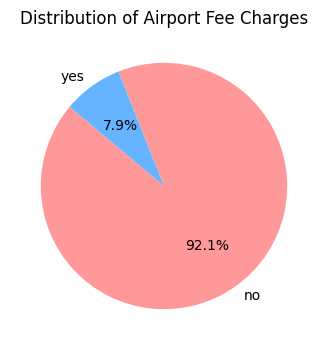

In [168]:
fee_counts = df_q3["is_airport_fee"].value_counts()

# Create a pie chart
plt.figure(figsize=(4, 4))
plt.pie(fee_counts, labels=fee_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Distribution of Airport Fee Charges')
plt.show()

I want to investigate which Borough's airport fee's where most frequent in.

In [169]:
df_q3_5 = df_q3.copy() # DONT RERUN THIS
df_q3 = df_q3.merge(location_df, left_on='PULocationID', right_on='LocationID', how='left')


In [170]:
df_q3.head()

,Airport_fee,PULocationID,DOLocationID,is_airport_fee,LocationID,Borough,Zone,service_zone
0,0.0,186,79,no,186,Manhattan,Penn Station/Madison Sq West,Yellow Zone
1,0.0,140,236,no,140,Manhattan,Lenox Hill East,Yellow Zone
2,0.0,236,79,no,236,Manhattan,Upper East Side North,Yellow Zone
3,0.0,79,211,no,79,Manhattan,East Village,Yellow Zone
4,0.0,211,148,no,211,Manhattan,SoHo,Yellow Zone


In [171]:
# Filter by yes
df_airport_fee_yes = df_q3[df_q3['is_airport_fee'] == 'yes']

In [172]:
df_airport_fee_yes["Borough"].value_counts()
# Queens has the highest airport fees leaving.

Borough
Queens           232263
Manhattan           244
Unknown             204
Brooklyn             28
Staten Island         1
Bronx                 1
Name: count, dtype: int64

In [173]:
df_q4 = df_q3_5.merge(location_df, left_on="DOLocationID", right_on='LocationID', how='left').copy()
df_q4.head()

,Airport_fee,PULocationID,DOLocationID,is_airport_fee,LocationID,Borough,Zone,service_zone
0,0.0,186,79,no,79,Manhattan,East Village,Yellow Zone
1,0.0,140,236,no,236,Manhattan,Upper East Side North,Yellow Zone
2,0.0,236,79,no,79,Manhattan,East Village,Yellow Zone
3,0.0,79,211,no,211,Manhattan,SoHo,Yellow Zone
4,0.0,211,148,no,148,Manhattan,Lower East Side,Yellow Zone


In [174]:
# Filter by yes
df_airport_fee_yes_DO = df_q4[df_q4['is_airport_fee'] == 'yes']

df_airport_fee_yes_DO["Borough"].value_counts()
# Queens has the highest airport fees leaving.

Borough
Manhattan        136613
Queens            46068
Brooklyn          36756
Bronx              5144
Unknown             535
Staten Island       320
EWR                 305
Name: count, dtype: int64

# Conclusion

Throughout this project, I gained valuable insights and skills, particularly regarding taxi patterns in New York City. Here are the key takeaways:

- Peak Times: Taxis are busiest between 4-5 PM and least busy between 4-5 AM.
- Airport Fees:
  - Most passengers paying airport fees and getting picked up are from Queens.
  - Most passengers paying airport fees and being dropped off are headed to Manhattan.
- Busy Days: Thursday is the busiest day for taxi drivers, indicating it’s an optimal day for finding taxi work.

Additionally, I learned about more efficient file formats for large datasets, such as Parquet files, which can be more effective than CSV files.